# Singly connected bonds

In this notebook we'll explore subsets of the spanning cluster and illustrate the _singly connected bonds_ of the spanning cluster. A singly connected bond is a collection of sites that connect two clusters by a single path. That is, if we remove a single site from this set we will create two separate clusters that are no longer connected.

In [1]:
import warnings
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import sklearn.linear_model

from walker import walk

In [2]:
sns.set(color_codes=True)

In [3]:
# Shape of system
shape = (100, 100)
# Critical probability for percolation
p_c = 0.59275
# Probability of set site
p = p_c #0.586
# Number if trials to create a percolating cluster
num_attempts = 1000

We create a system which contains a percolating cluster. This is needed for the walker algorithm to work.

In [4]:
for i in tqdm.tqdm_notebook(range(num_attempts)):
    z = np.random.rand(*shape) < p
    labels, num_features = scipy.ndimage.measurements.label(z)

    # Find label of percolating cluster. This is done by checking if a
    # label exists in both the uppermost and the lowermost rows of the
    # image.
    label_percolating = np.intersect1d(labels[0, :], labels[-1, :])

    # We ignore the infinite system , i.e., the label 0
    perc_label = label_percolating[label_percolating > 0]

    # If we find a spanning cluster, break the loop
    if len(perc_label) > 0:
        print(f"Percolating cluster found!")
        break

Percolating cluster found!



Having found a system with a percolating cluster and extracted the label of the spanning cluster, we proceed to compute the mass of each cluster and fetch the sites contained in the spanning cluster.

In [5]:
label_list = np.arange(num_features + 1)
area = scipy.ndimage.measurements.sum(z, labels, index=label_list)
area_image = area[labels]
spanning_cluster = labels == perc_label[0]

Below we plot all the connected clusters in the system and color them proportionally to their mass. That is, a high mass yields a bright color and vice versa.

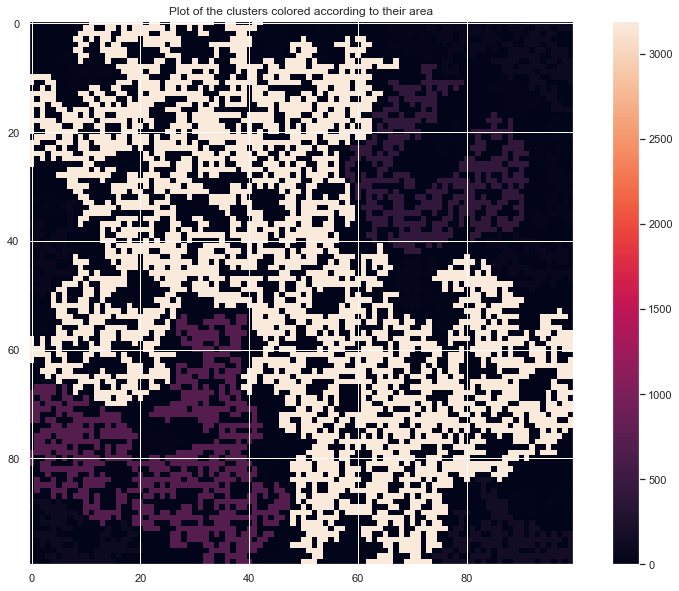

In [6]:
plt.figure(figsize=(14, 10))

plt.imshow(area_image, interpolation="nearest", origin="upper")
plt.colorbar()
plt.title("Plot of the clusters colored according to their area")
plt.show()

In [7]:
print(f"Area of largest cluster: {np.max(area)}")
print(f"Area of second largest cluster: {np.sort(area)[-2]}")

Area of largest cluster: 3193.0
Area of second largest cluster: 722.0


We proceed to show a plot of the spanning cluster without any of the other clusters.

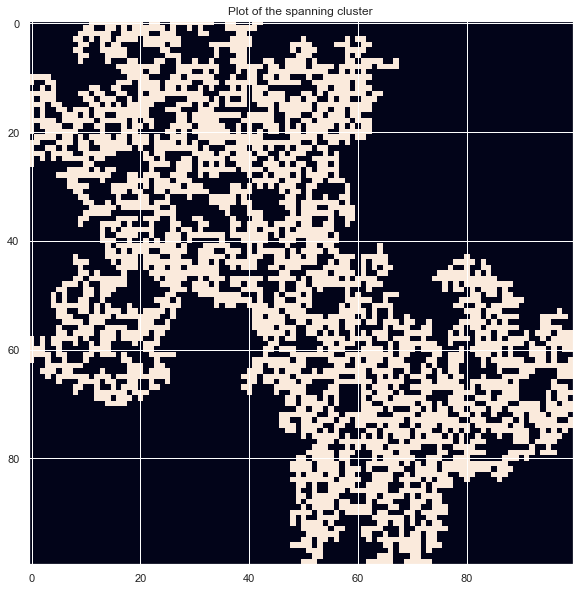

In [8]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, interpolation="nearest", origin="upper")
plt.title("Plot of the spanning cluster")
plt.show()

Here we can see the sites contained in the spanning cluster visualized. Next we perform a left-right walk on the spanning cluster in order to find singly connected bonds, the backbone of the cluster and the dangling ends.

In [9]:
left, right = walk(spanning_cluster)

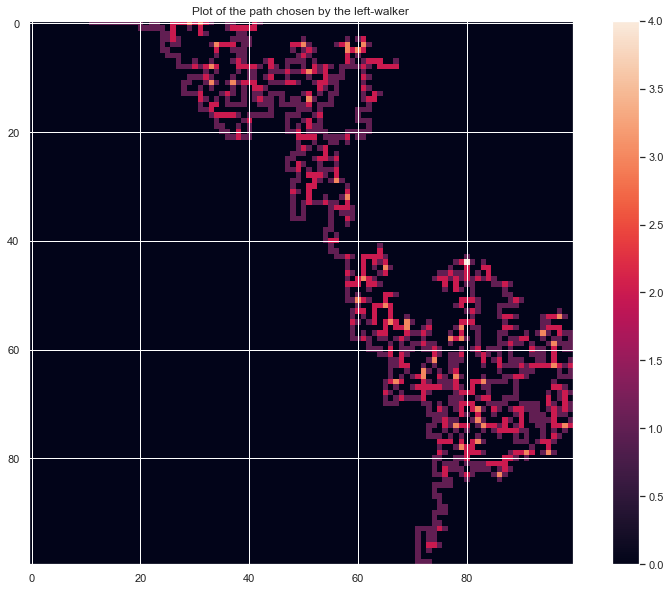

In [10]:
plt.figure(figsize=(14, 10))

plt.imshow(left, interpolation="nearest", origin="upper")
plt.colorbar()
plt.title("Plot of the path chosen by the left-walker")
plt.show()

In this image we see the path chosen by the left-walker. Bright colors signifies that a site is visited more than once.

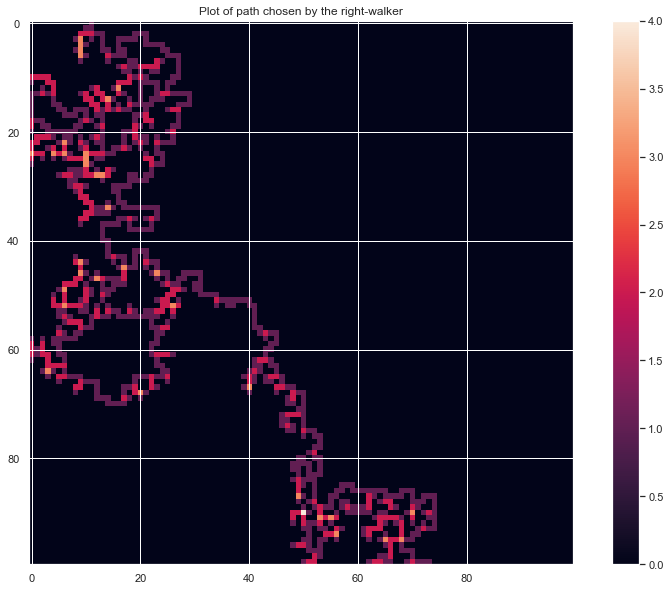

In [11]:
plt.figure(figsize=(14, 10))

plt.imshow(right, interpolation="nearest", origin="upper")
plt.colorbar()
plt.title("Plot of path chosen by the right-walker")
plt.show()

Note that path is found by starting from the top of the spanning cluster, i.e., at row `0`, and the walkers move downwards to higher row numbers.

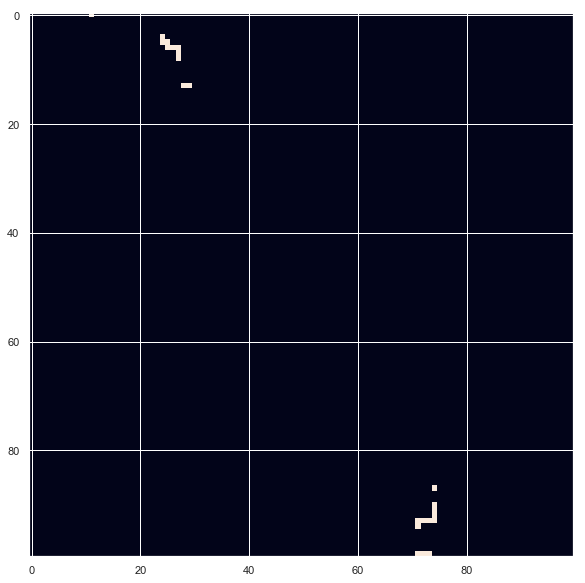

In [12]:
plt.figure(figsize=(14, 10))

plt.imshow((left * right) > 0, interpolation="nearest", origin="upper")
plt.show()

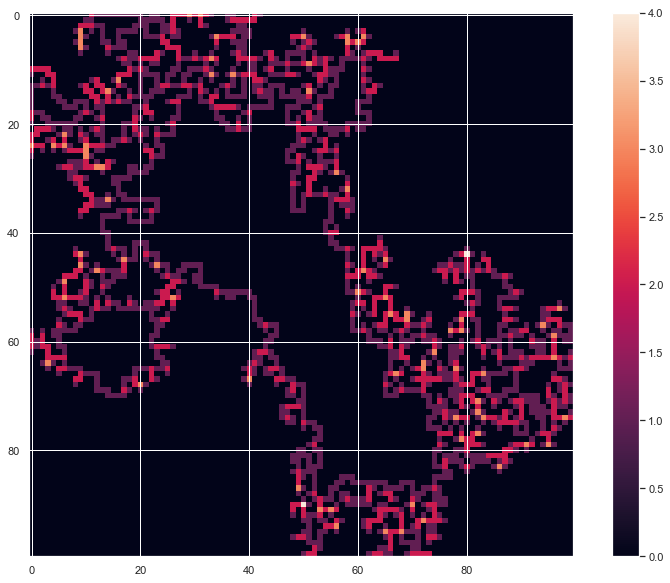

In [13]:
plt.figure(figsize=(14, 10))

plt.imshow(left + right, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

## Computing the mass of the singly connected bonds

We can find the set of sites in the singly connected bonds by multiplying the `right` and `left` arrays. A singly connected site is a site where both `right > 0` and `left > 0`.

In [14]:
print(f"Mass SC: {np.sum((right * left) > 0)}")

Mass SC: 23


We expect the mass of the singly connected sites, $M_{SC}$, to scale as
\begin{gather}
    M_{SC} \propto L^{D_{SC}}
    \implies
    \log(M_{SC}) = \log(C) + D_{SC} \log(L),
\end{gather}
where $D_{SC}$ is the _fractal dimension_ of the singly connected bonds and $C$ is a constant. To estimate $D_{SC}$ we compute the mass of the singly connected bonds for several system sizes $L$.

In [15]:
def compute_mass_sc(L, num_samples, num_attempts=1000, p=p_c):
    mass_arr = np.zeros(num_samples)
    for i in tqdm.tqdm_notebook(range(num_samples)):
        for attempt in range(num_attempts):
            z = np.random.rand(L, L) < p
            labels, num_features = scipy.ndimage.measurements.label(z)
            label_percolating = np.intersect1d(labels[0, :], labels[-1, :])
            perc_label = label_percolating[label_percolating > 0]

            # If we find a spanning cluster, break the loop
            if len(perc_label) > 0:
                break

        else:
            warnings.warn("Percolating cluster not found!")

        spanning_cluster = labels == perc_label[0]
        left, right = walk(spanning_cluster)

        mass_arr[i] = np.sum((left * right) > 0)

    return mass_arr

In [16]:
num_samples = 100
L_list = list(map(lambda x: x * 100, range(1, 11)))
mass_list = []

In [17]:
for L in L_list:
    mass_arr = compute_mass_sc(L, num_samples)
    mass_list.append(np.mean(mass_arr))

In [18]:
clf = sklearn.linear_model.LinearRegression().fit(
    np.log(L_list)[:, np.newaxis], np.log(mass_list)[:, np.newaxis]
)

D_sc = clf.coef_[0, 0]
log_C = clf.intercept_[0]

print(f"Singly-connected fractal dimension: {D_sc}")

Singly-connected fractal dimension: 0.7630027311558977


The true value of the fractal dimension is given by
\begin{align}
    D_{SC} = \frac{3}{4} = 0.75,
\end{align}
which we see is quite close to the value we find.

In [19]:
D_sc_true = 3 / 4

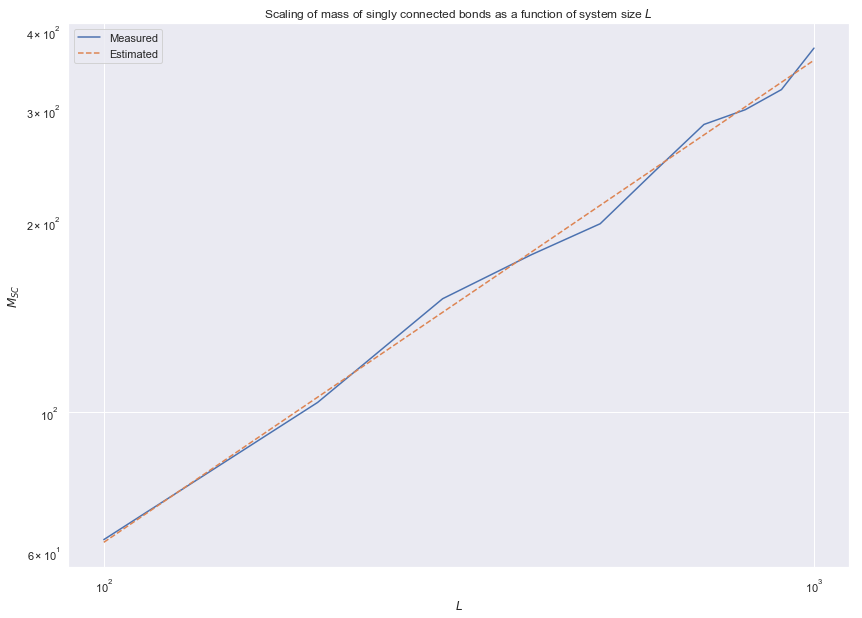

In [20]:
plt.figure(figsize=(14, 10))

plt.loglog(L_list, mass_list, label="Measured")
plt.loglog(
    L_list,
    np.exp(log_C) * np.array(L_list) ** D_sc,
    "--",
    label=r"Estimated",
)
plt.legend(loc="best")
plt.title(r"Scaling of mass of singly connected bonds as a function of system size $L$")
plt.xlabel(r"$L$")
plt.ylabel(r"$M_{SC}$")
plt.show()

In this figure we can see how the mass of the singly connected bonds scales as a function of the system size $L$. Using linear regression we estimate the fractal dimension of the singly connected bonds as shown above.

We now proceed to find the behaviour of the density of the singly connected bonds by
\begin{align}
    P_{SC} = \frac{M_{SC}}{L^d},
\end{align}
where $d = 2$ is the dimension of the system. We find the density as a function of $p - p_c$.

In [21]:
p_arr = np.linspace(p_c, 0.7, 11)
p_min_pc = p_arr - p_c

L_arr = np.array([100, 200, 500, 1000])
mass_sc = np.zeros((len(L_arr), len(p_arr)))

M = 100

In [22]:
for i, L in enumerate(L_arr):
    for j, p in enumerate(p_arr):
        mass_sc[i, j] = np.mean(compute_mass_sc(L, M, p=p))

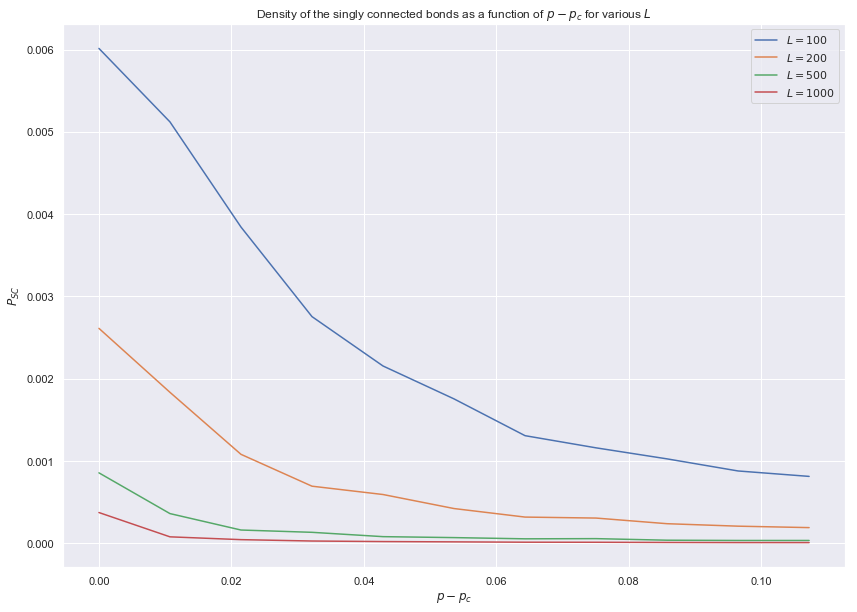

In [23]:
plt.figure(figsize=(14, 10))

for i, L in enumerate(L_arr):
    plt.plot(
        p_min_pc,
        mass_sc[i] / L ** 2,
        label=fr"$L = {L}$",
    )

plt.legend(loc="best")
plt.title(r"Density of the singly connected bonds as a function of $p - p_c$ for various $L$")
plt.xlabel(r"$p - p_c$")
plt.ylabel(r"$P_{SC}$")
plt.show()

In the above figure we can see how the density decreases as the system size $L$ increases. We have only included values for $p \geq p_c$ as $p < p_c$ seldom contains a spanning cluster. For $p = p_c$ we on average get the smallest spanning cluster with the highest amount of singly connected bonds (confirmed from the plot), whereas a higher value of $p$ gives more dense spanning clusters. This means that the mass of the singly connected bonds sink. We can therefore expect to observe a trend where
\begin{align}
    P_{SC} \propto |p - p_c|^{-\gamma},
\end{align}
which is only applicable as $p \to p_c$. Fixing the system size $L$ and taking the logarithm on both sides we can estimate $-\gamma$ by linear regression.
\begin{align}
    \log\left( P_{SC} \right) = \log(C) - \gamma \log\left(| p - p_c | \right),
\end{align}
where $C$ is a constant.

In [24]:
L = 500
M = 1000
p_arr = np.linspace(p_c, 0.8, 11)[1:]
p_min_pc = np.abs(p_arr - p_c)
P_arr = np.zeros_like(p_min_pc)

In [25]:
for i, p in enumerate(p_arr):
    mass = np.mean(compute_mass_sc(L, M, p=p))
    P_arr[i] = mass / L ** 2

In [26]:
clf = sklearn.linear_model.LinearRegression().fit(
    np.log(p_min_pc[:, np.newaxis]), np.log(P_arr[:, np.newaxis]),
)

gamma = -clf.coef_[0, 0]
log_C = clf.intercept_[0]

print(f"gamma = {gamma}")

gamma = 1.0442599879955523


We see that $\gamma$ is very close to $1$.

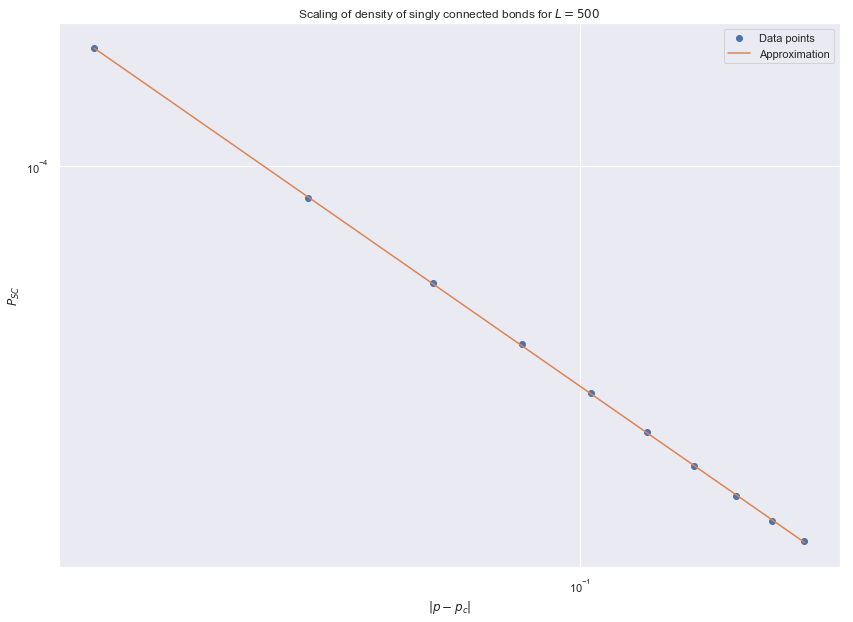

In [27]:
plt.figure(figsize=(14, 10))

plt.loglog(p_min_pc, P_arr, "o", label="Data points")
plt.loglog(
    p_min_pc,
    np.exp(log_C) * p_min_pc ** (-gamma),
    label="Approximation"
)

plt.legend(loc="best")
plt.title(fr"Scaling of density of singly connected bonds for $L = {L}$")
plt.xlabel(r"$|p - p_c|$")
plt.ylabel(r"$P_{SC}$")
plt.show()

In the figure above we can see how the density of the singly connected bonds follows a power law for $p \to p_c$.